In [2]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder \
      .master("spark://192.168.40.242:7077") \
      .appName("lakehead_University_Enrollement_Trends") \
      .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/01 20:28:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
from pymongo import MongoClient

# Connect to MongoDB running on localhost
client = MongoClient('mongodb://localhost:27017/')

# Connect to the 'big_data' database
db = client['big_data']

# Access the 'lakehead_enrollment' collection
collection = db['lakehead_enrollment']


In [10]:
import pandas as pd

# Retrieve all documents from the collection
data = collection.find()

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(list(data))

# Display the first few rows
df.head()

,_id,Unique ID,Application Submitted Date,College,Application Program,Application Start Term,Decision Reason,Application Scholarship Tier,Admit Date,Confirm/Deny Date,Age,Person Sex,Person Race,Person Citizenship Status,Country,Registered in Colleague
0,674cf61ef789b808d711422b,999789535,10/10/23,Albers School of Business,Business Administration (Professional) - MBA -...,Winter 2024,Deposit - Not Required,2023-G0 - $0,10/16/2023,10/16/2023,33,M,White,US,United States,1
1,674cf61ef789b808d711422c,982505163,19/12/23,Albers School of Business,Sport and Entertainment Management - MBA,Winter 2024,Deposit - Not Required,2023-G0 - $0,01/08/24,01/09/24,23,M,Black or African American,US,United States,0
2,674cf61ef789b808d711422d,999851695,31/01/21,College of Education,"Counseling, Clinical Mental Health Counseling ...",Fall 2021,Admit Declined,2021-G2 - $2400,03/13/2021,03/13/2021,26,F,Unknown,US,United States,0
3,674cf61ef789b808d711422e,999050220,06/10/23,College of Science and Engineering,Computer Science - MSCS,Spring 2024,Admit Conditional & Bridge,2023-G4 - $4800,11/15/2023,11/15/2023,22,M,Asian,FN,India,0
4,674cf61ef789b808d711422f,970859007,12/05/23,College of Science and Engineering,Computer Science Fundamentals Certificate,Winter 2024,Admit Declined,2023-G0 - $0,05/24/2023,05/24/2023,25,F,Asian - Asian American,US,United States,0


   Unique ID Application Submitted Date                             College  \
0  999789535                   10/10/23           Albers School of Business   
1  982505163                   19/12/23           Albers School of Business   
2  999851695                   31/01/21                College of Education   
3  978092429                   15/12/23           Albers School of Business   
4  976965474                   28/03/22  College of Science and Engineering   

                                 Application Program Application Start Term  \
0  Business Administration (Professional) - MBA -...            Winter 2024   
1           Sport and Entertainment Management - MBA            Winter 2024   
2  Counseling, Clinical Mental Health Counseling ...              Fall 2021   
3  Business Administration (Professional) - MBA -...            Winter 2024   
4          Computer Science Fundamentals Certificate            Winter 2024   

                    Decision Reason Application Sc

/var/folders/7c/k867kvvd2vs8p3pt2y5tbn200000gn/T/ipykernel_11592/917668459.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=14, fontweight='bold')


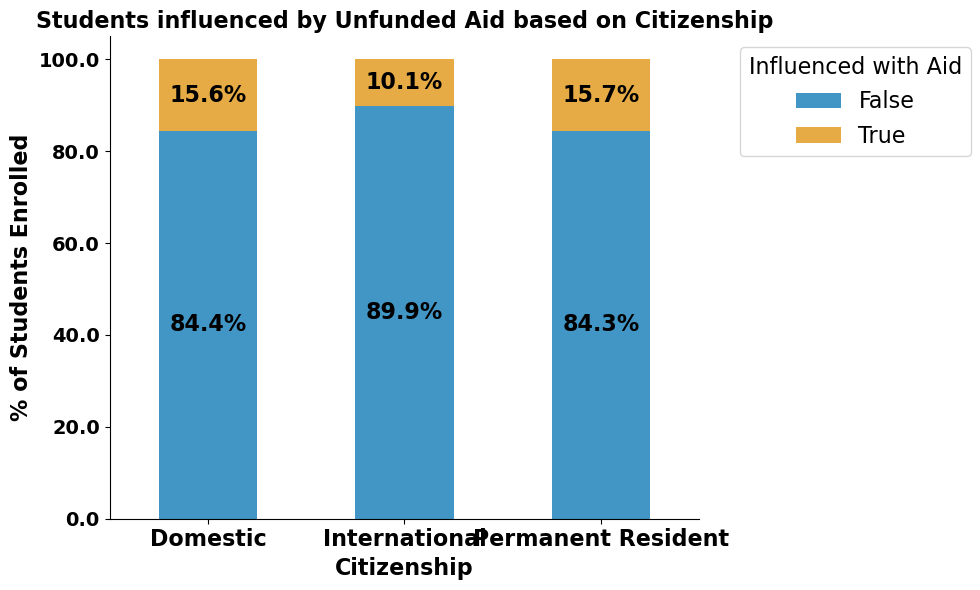

/var/folders/7c/k867kvvd2vs8p3pt2y5tbn200000gn/T/ipykernel_11592/917668459.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=14, fontweight='bold')


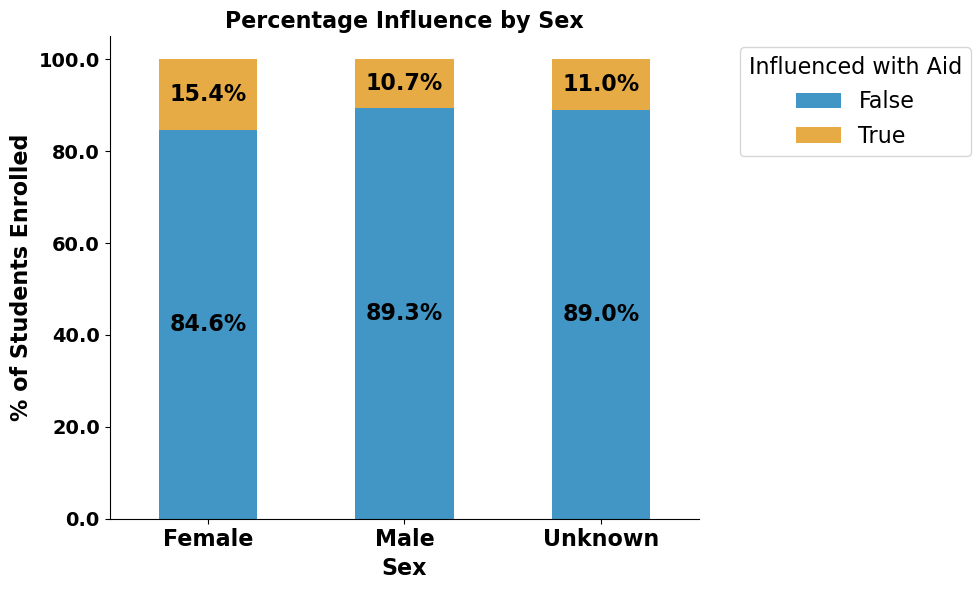

/var/folders/7c/k867kvvd2vs8p3pt2y5tbn200000gn/T/ipykernel_11592/917668459.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=14, fontweight='bold')


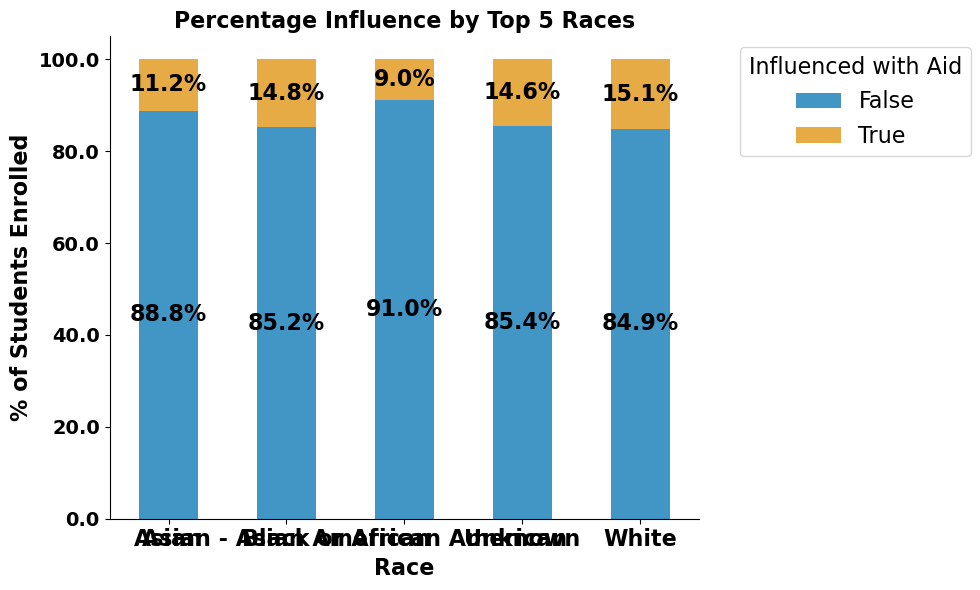

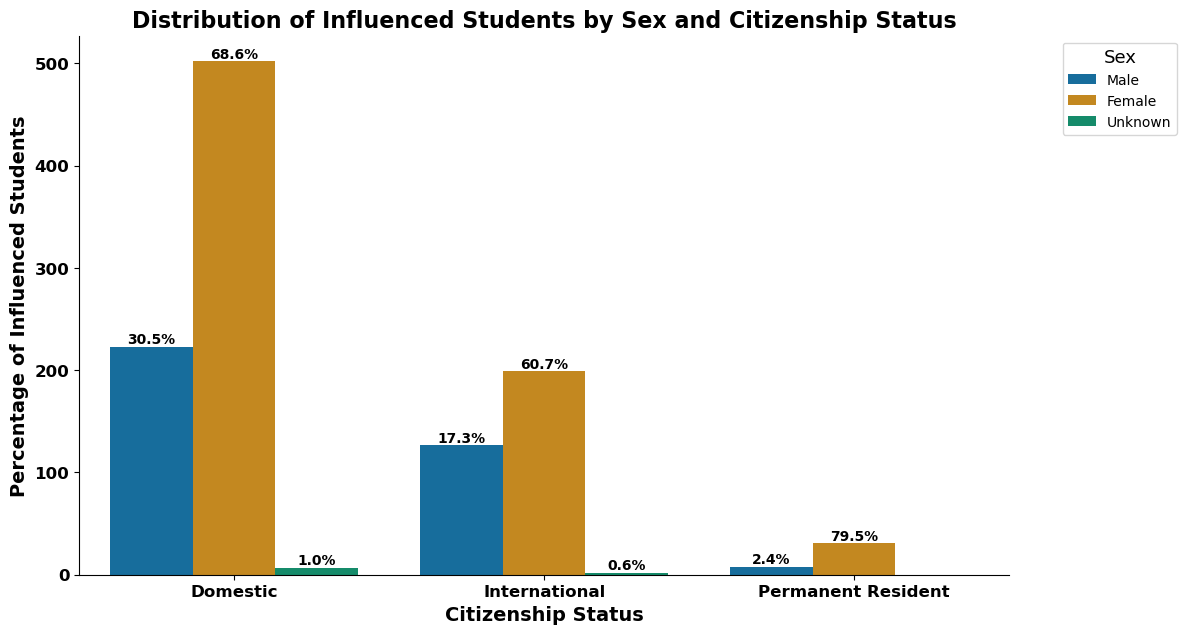

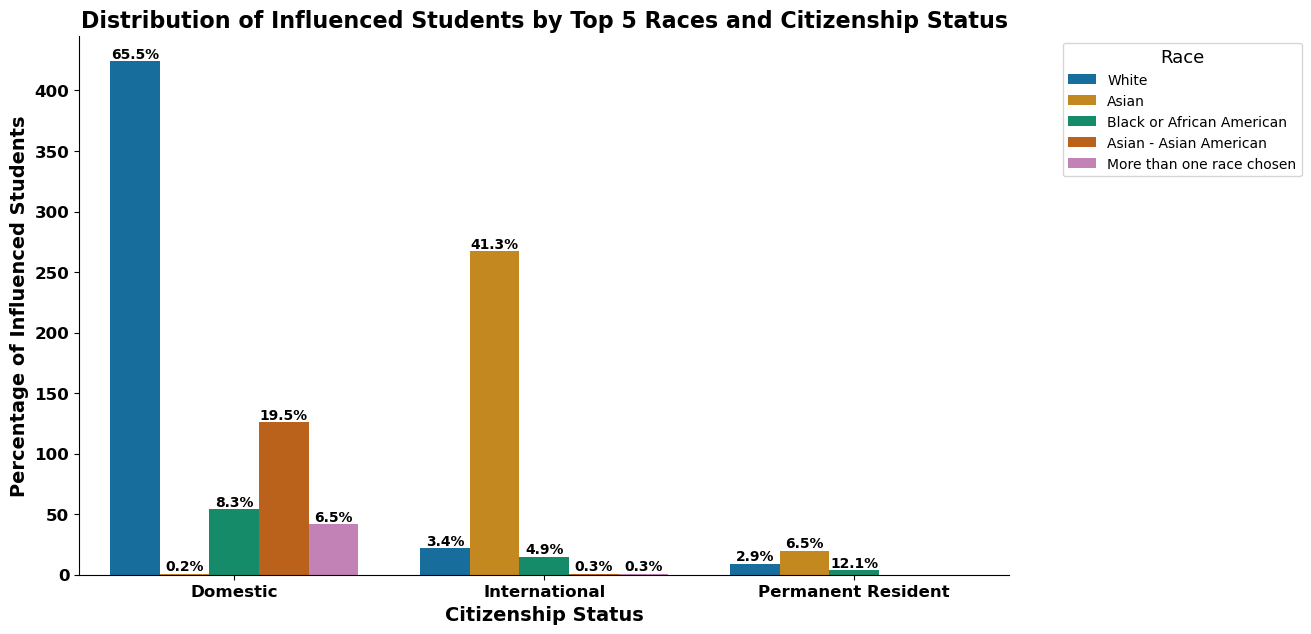

<Figure size 1200x700 with 0 Axes>

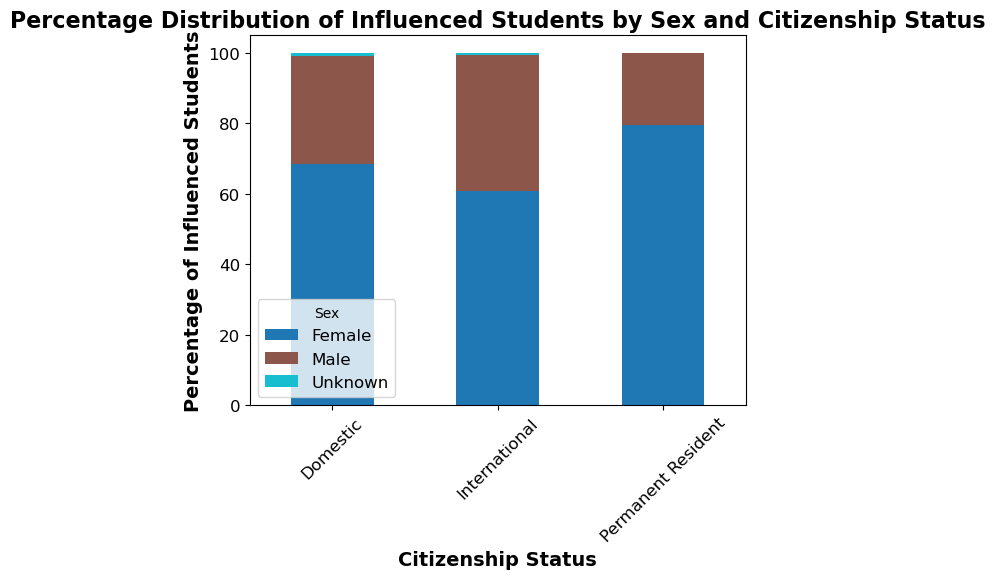

<Figure size 1200x700 with 0 Axes>

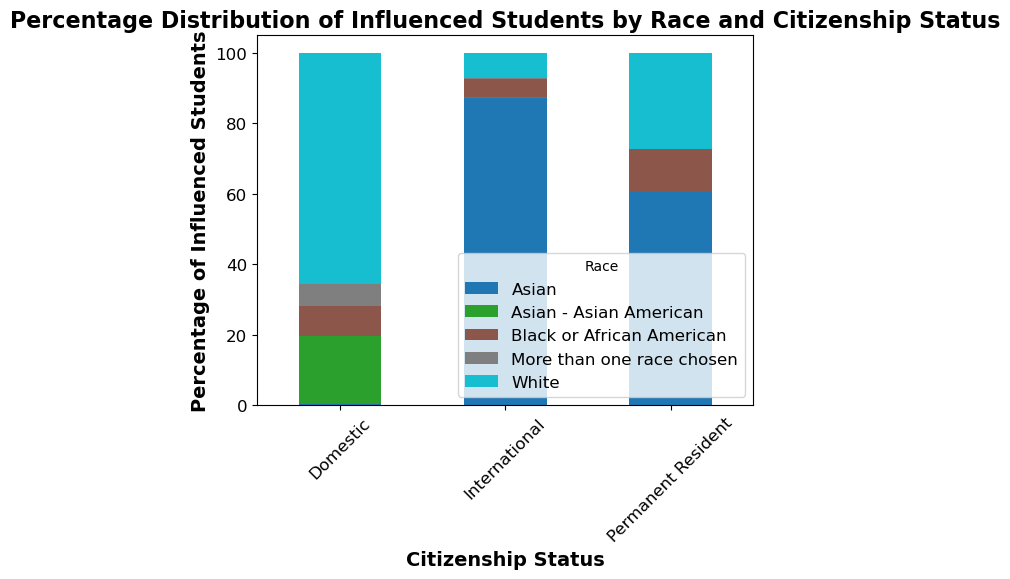

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

# Load the CSV file into a DataFrame
data = pd.read_csv('lakehead_dataset.csv')

# Display the first few rows of the dataframe and the column names to understand the dataset
print(data.head())
print(data.columns)

# Adjust scholarship values for 2022-G1 with $0
data['Application Scholarship Tier'] = data['Application Scholarship Tier'].replace('2022-G1 - $0', '2022-G0 - $0')

# Update the 'Scholarship Amount' based on the corrected tier
data['Scholarship Amount'] = data['Application Scholarship Tier'].apply(
    lambda x: int(x.split('- $')[-1]) if '$' in x else 0
)

# Define decision categories
influenced_decision_categories = [
    'Admit Conditional', 'Admit Conditional & Bridge', 'Admit Conditional & Probationary',
    'Admit Probation', 'Admit Regular', 'Deposit - Not Required', 'Deposit Paid',
    'Deposit Waived/Not Required'
]

not_influenced_decision_categories = [
    'Admit Declined - Post Enroll(CF)', 'No Show - Post Enroll(CF)', 'Admit Declined'
]

# Define 'Influenced with Aid' and 'Not Influenced with Aid'
data['Influenced with Aid'] = data.apply(
    lambda row: row['Scholarship Amount'] > 0 and row['Registered in Colleague'] == 1 and
                row['Decision Reason'] in influenced_decision_categories, axis=1
)

data['Not Influenced with Aid'] = data.apply(
    lambda row: row['Scholarship Amount'] > 0 and (row['Registered in Colleague'] == 0 or
                                                  row['Decision Reason'] in not_influenced_decision_categories), axis=1
)

# Categorize citizenship and standardize sex
citizenship_map = {'US': 'Domestic', 'PR': 'Permanent Resident', 'FN': 'International'}
sex_map = {'M': 'Male', 'F': 'Female'}
data['Citizenship Category'] = data['Person Citizenship Status'].map(citizenship_map).fillna('Unknown')
data['Standardized Sex'] = data['Person Sex'].map(sex_map).fillna('Unknown')

# Filter out unknown citizenship
filtered_data = data[data['Citizenship Category'] != 'Unknown']

# Plotting function with external legend
def plot_percentage_with_external_legend(df, x, hue, title, xlabel):
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    group_counts = df.groupby(x)[hue].count()
    hue_counts = df.groupby([x, hue]).size().unstack()
    hue_percentage = hue_counts.div(group_counts, axis=0) * 100
    bars = hue_percentage.plot(kind='bar', stacked=True, ax=ax, color=sns.color_palette("colorblind"), alpha=0.75)
    ax.set_ylabel('% of Students Enrolled', fontsize=16, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=16, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    for bar in bars.containers:
        ax.bar_label(bar, fmt='%.1f%%', label_type='center', fontsize=16, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=16, fontweight='bold')
    ax.set_yticklabels(ax.get_yticks(), fontsize=14, fontweight='bold')
    plt.legend(title=hue, title_fontsize='16', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, frameon=True)
    plt.tight_layout()
    plt.grid(False)
    sns.despine(left=False, bottom=False)  # To remove the borders
    plt.show()

# Generate plots
plot_percentage_with_external_legend(filtered_data, 'Citizenship Category', 'Influenced with Aid',
                                     'Students influenced by Unfunded Aid based on Citizenship', 'Citizenship')
plot_percentage_with_external_legend(data, 'Standardized Sex', 'Influenced with Aid',
                                     'Percentage Influence by Sex', 'Sex')

top_races = data['Person Race'].value_counts().nlargest(5).index
race_data = data[data['Person Race'].isin(top_races)]
plot_percentage_with_external_legend(race_data, 'Person Race', 'Influenced with Aid',
                                     'Percentage Influence by Top 5 Races', 'Race')

# Filter only influenced students
influenced_data = data[data['Influenced with Aid']]

# Filter out 'Unknown' races
filtered_influenced_data = influenced_data[influenced_data['Person Race'] != 'Unknown']
top_races_influenced = filtered_influenced_data['Person Race'].value_counts().nlargest(5).index

# Helper function to add percentage labels to the bars
def add_percentage_labels(ax, data):
    total_counts = data.groupby('Citizenship Category').size()
    for p in ax.patches:
        height = p.get_height()
        if height == 0:  # Skip zero height bars
            continue
        category = p.get_x() + p.get_width() / 2.0
        total = total_counts.loc[data['Citizenship Category'].unique()[int(category)]]
        percentage = (height / total) * 100
        if percentage > 0:  # Only annotate bars with a non-zero percentage
            ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', fontsize=10, fontweight='bold', color='black', xytext=(0, 5),
                        textcoords='offset points')

# Visualization for Influenced Students by Sex and Citizenship Status
plt.figure(figsize=(12, 7))
ax = sns.countplot(x='Citizenship Category', hue='Standardized Sex', data=influenced_data, palette='colorblind')
plt.title('Distribution of Influenced Students by Sex and Citizenship Status', fontsize=16, fontweight='bold')
plt.xlabel('Citizenship Status', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Influenced Students', fontsize=14, fontweight='bold')
plt.legend(title='Sex', title_fontsize='13', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
add_percentage_labels(ax, influenced_data)
sns.despine(left=False, bottom=False)  # To remove the borders
plt.show()

# Visualization for Influenced Students by Top 5 Races and Citizenship Status
plt.figure(figsize=(12, 7))
ax = sns.countplot(x='Citizenship Category', hue='Person Race', data=filtered_influenced_data[filtered_influenced_data['Person Race'].isin(top_races_influenced)], palette='colorblind')
plt.title('Distribution of Influenced Students by Top 5 Races and Citizenship Status', fontsize=16, fontweight='bold')
plt.xlabel('Citizenship Status', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Influenced Students', fontsize=14, fontweight='bold')
plt.legend(title='Race', title_fontsize='13', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
add_percentage_labels(ax, filtered_influenced_data[filtered_influenced_data['Person Race'].isin(top_races_influenced)])
sns.despine(left=False, bottom=False)  # To remove the borders
plt.show()

# Plotting percentages for sex and races
sex_counts = influenced_data.groupby(['Citizenship Category', 'Standardized Sex']).size().unstack(fill_value=0)
sex_totals = sex_counts.sum(axis=1)
sex_percentages = sex_counts.div(sex_totals, axis=0) * 100

race_counts = filtered_influenced_data[filtered_influenced_data['Person Race'].isin(top_races_influenced)].groupby(['Citizenship Category', 'Person Race']).size().unstack(fill_value=0)
race_totals = race_counts.sum(axis=1)
race_percentages = race_counts.div(race_totals, axis=0) * 100

# Plot for Influenced Students by Sex and Citizenship Status with percentages
plt.figure(figsize=(12, 7))
ax = sex_percentages.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Percentage Distribution of Influenced Students by Sex and Citizenship Status', fontsize=16, fontweight='bold')
plt.xlabel('Citizenship Status', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Influenced Students', fontsize=14, fontweight='bold')
plt.legend(title='Sex', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plot for Influenced Students by Top 5 Races and Citizenship Status with percentages
plt.figure(figsize=(12, 7))
ax = race_percentages.plot(kind='bar', stacked=True, colormap='tab10')
plt.title('Percentage Distribution of Influenced Students by Race and Citizenship Status', fontsize=16, fontweight='bold')
plt.xlabel('Citizenship Status', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Influenced Students', fontsize=14, fontweight='bold')
plt.legend(title='Race', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()
